In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import scipy.stats as stats

Next, we are going to load the X and Y data. 
We start our EDA by univariate analysis by providing some basic statistics on each feature to get an initial understanding of min/max/median/mean for each feature in X and also the Y values.

We also compute the number of missing features in total. Fortunately there are not that many missing features. 

In [5]:
# Load the dataset
file_path = '/Users/mobin/Documents/quant finance Interview/My interviews/Aquatic/Data_Exercise_V2/'

X = pd.read_csv(file_path + 'X.csv')
y = pd.read_csv(file_path + 'Y.csv', header=None)

print(y.columns)

# Renaming the columns to 'index' and 'Y'
y.columns = ['index', 'Y']
print(y.columns)

X.set_index(X.columns[0], inplace=True)
y.set_index(y.columns[0], inplace=True)

# Merging the dataframes based on the new index
data = pd.merge(X, y, left_index=True, right_index=True)

print("data head is: ", data.head())
print(data.info())


# Univariate Analysis
# Check for missing values
missing_values = data.isnull().sum()
print("Number of missing values per column:\n", missing_values)



Int64Index([0, 1], dtype='int64')
Index(['index', 'Y'], dtype='object')
data head is:                     0         1         2         3         4          Y
Unnamed: 0                                                             
0           0.652814 -0.795411  0.939938 -1.416972  2.884459   7.411771
1          -3.313870  2.300480 -1.262742  2.128255  1.748513  45.082121
2           3.609352 -3.417029  0.529676 -8.943355  1.542994 -57.310678
3           0.977559 -4.377676 -1.250228 -1.055279 -0.071893 -19.190323
4           0.595619  6.729869  0.487150  4.534389  3.922560  -7.259200
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9998 non-null   float64
 1   1       9997 non-null   float64
 2   2       9999 non-null   float64
 3   3       9999 non-null   float64
 4   4       9989 non-null   float64
 5   Y       10000 non-null  float64
dtypes

In [6]:
# Basic statistical summary
# Statistical summary for X and y
print("\nStatistical summary of each X column feature, and Y value:")
statistical_summary = data.describe()
print(statistical_summary)

data = data.fillna(data.mean())


Statistical summary of each X column feature, and Y value:
                  0             1             2             3             4  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       1.019668      0.049666      0.105662      0.336831      1.039732   
std      100.036322      5.459886     10.024118     59.780242      2.128940   
min       -7.654205    -19.706080     -3.726699  -3001.334527     -7.265781   
25%       -1.303321     -3.630220     -0.597153     -3.907858     -0.402370   
50%        0.012648      0.049666      0.008189      0.050970      1.032799   
75%        1.359666      3.699497      0.613171      4.135878      2.474292   
max    10001.660383     19.256933    998.329754   5134.656375      9.896021   

                  Y  
count  10000.000000  
mean       1.183616  
std       54.743893  
min     -712.340073  
25%      -17.473542  
50%        1.943772  
75%       21.275091  
max      681.761316  


We continue our univariate analysis and plot frequency plot of each feature, showing its distribution.


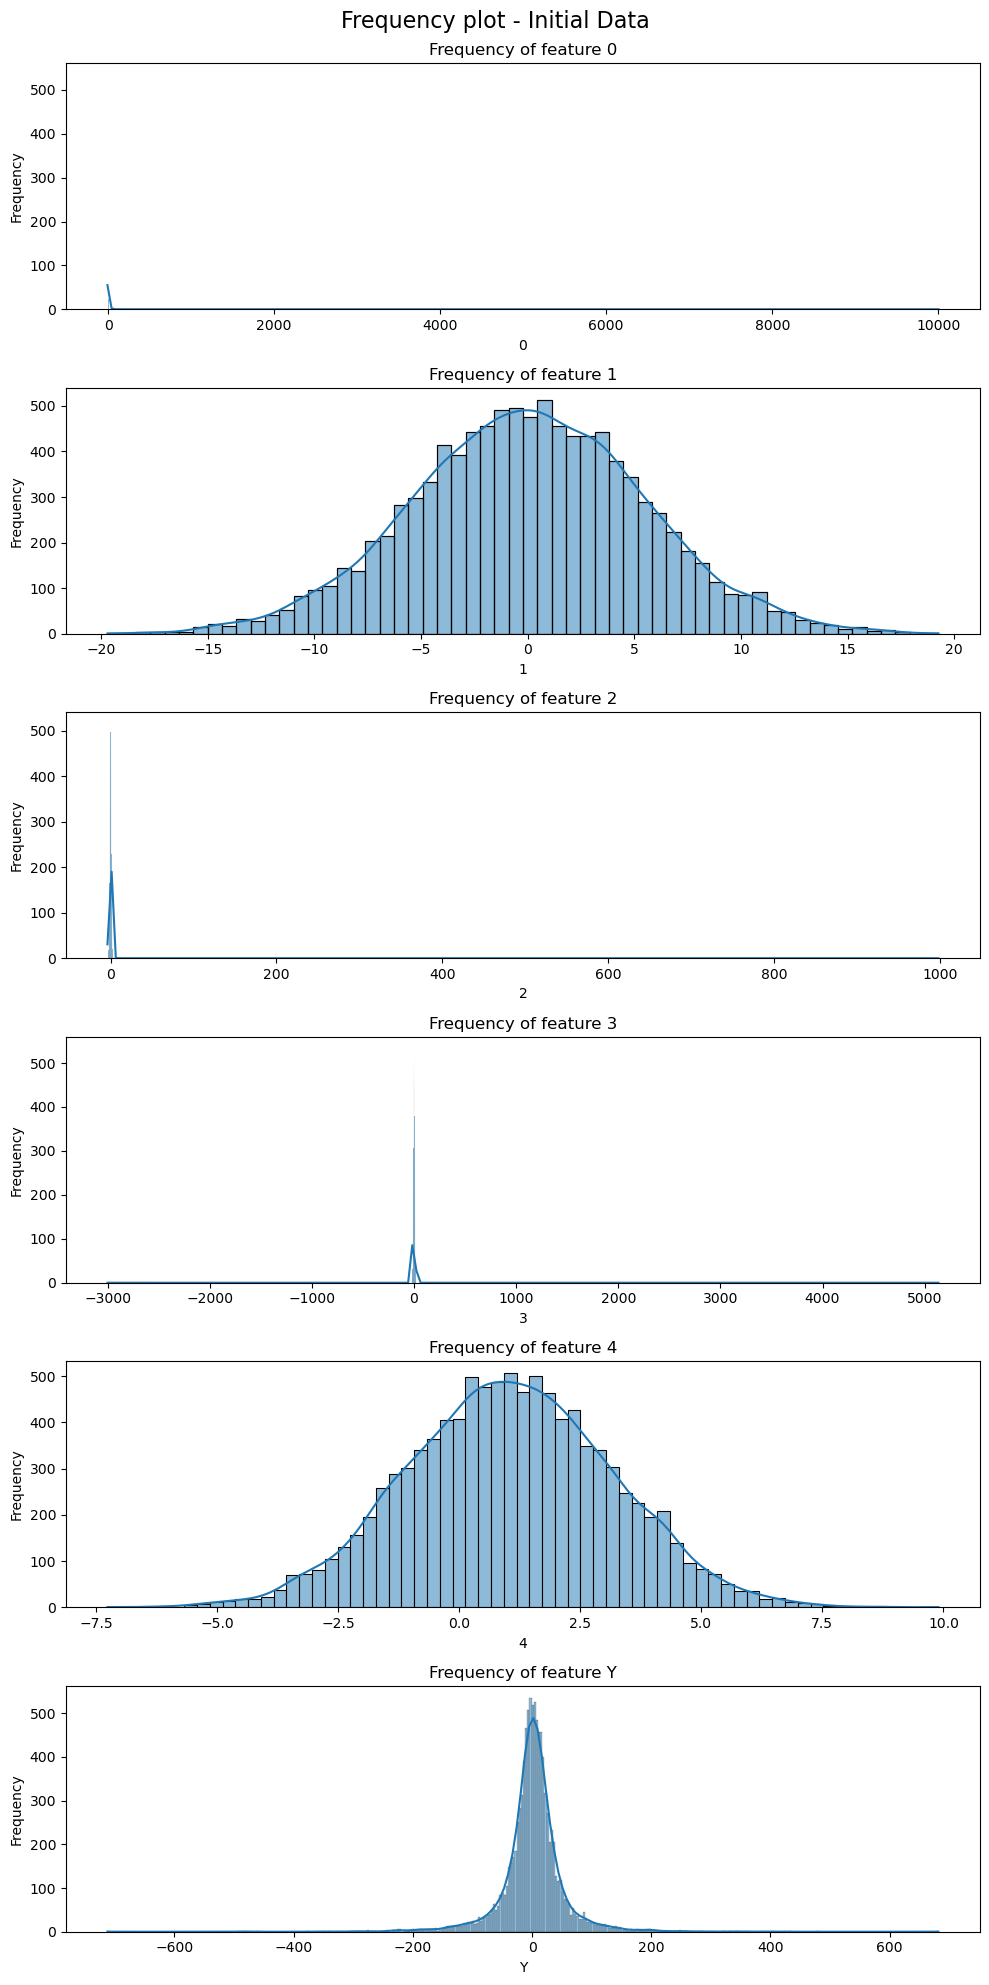

In [4]:
plt.figure(figsize=(10, 20))  # Adjusting the figure size for better visibility
plt.suptitle('Frequency plot - Initial Data', fontsize=16, y=0.99)

# Plotting each feature in a separate row
for i, col in enumerate(data.columns):
    plt.subplot(6, 1, i + 1)  # Creating a subplot for each feature
    sns.histplot(data[col], kde=True)
    plt.title(f'Frequency of feature {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

We can see features 1 and 4 are normally distributed, so we don't need to do much (we just later scale them to have all our features within same range)

Given the way features 0,2,3 are distributed, we need to do something!!

I initially used log-scaling to normalize the data the long tail of the feature distribution. But later, upon further examination of data I realized the long tail is due to outliers.
I found this using the figures below. Hence, I changed the outlier feature values, and capped it at Q1 - 3 * IQR for lower bound, and Q3 + 3 * IQR for upper bound. The constant 3 in  3 * IQR was selected by observing the data (anything else greater than ~2 would also work). 
Note that we didn't drop the outliers, we just replaced the corresponding feature value with the designated upper/lower bound. 

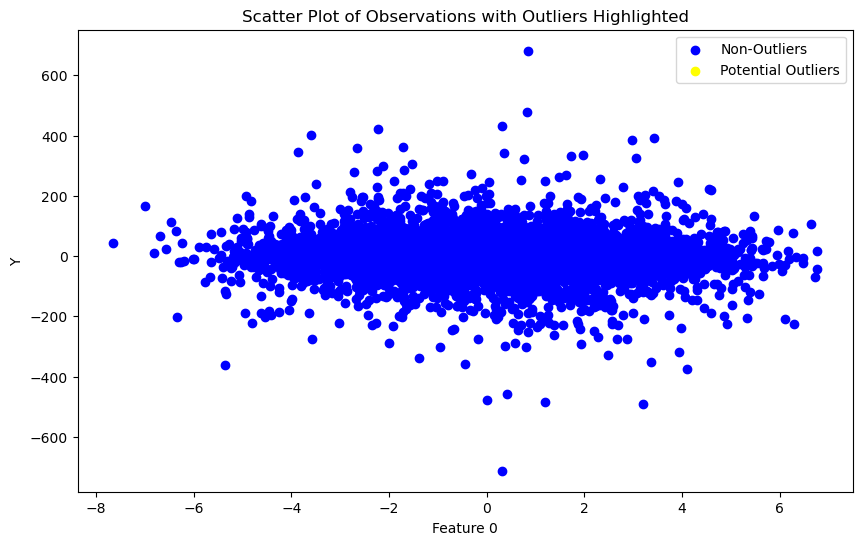

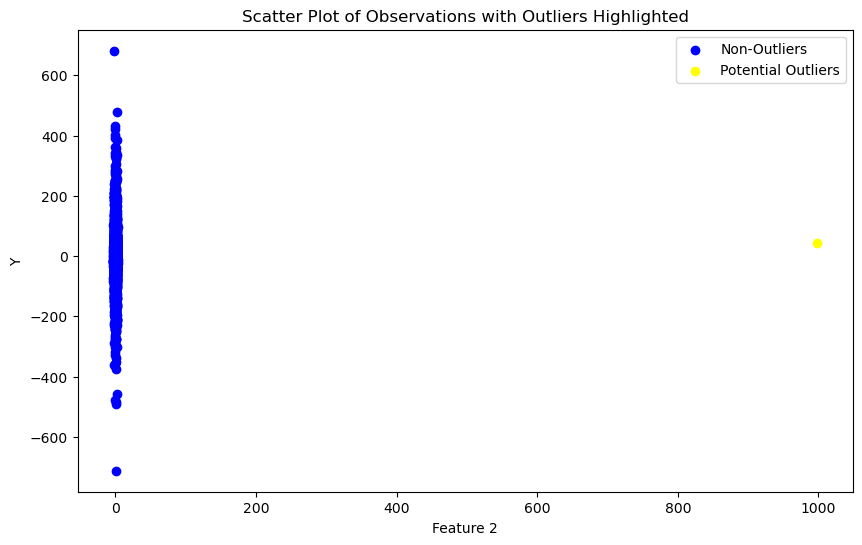

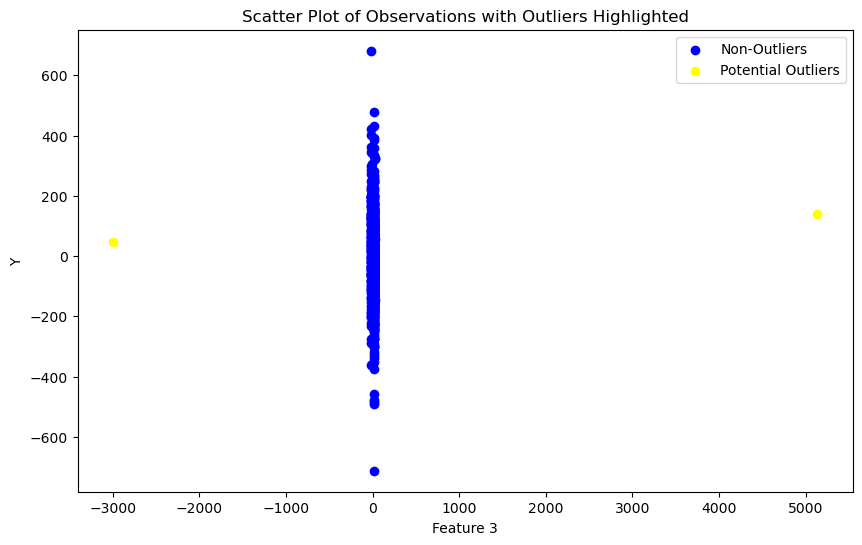

In [5]:
for i, col in enumerate(["0", "2", "3"]):
    # Find the index of the row with the maximum value in feature col
    if col == "0":
        index_to_drop = data[col].idxmax()
        # Drop that row
        data = data.drop(index_to_drop)

    # Calculating IQR
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    # Determining non-outlier bounds
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Determining outliers
    outliers = (data[col] < lower_bound) | (data[col] > upper_bound)

    # Scatter plot
    plt.figure(figsize=(10, 6))

    # Plot non-outliers in blue
    plt.scatter(data.loc[~outliers, col], data.loc[~outliers, 'Y'], color='blue', label='Non-Outliers')

    # Plot outliers in yellow
    plt.scatter(data.loc[outliers, col], data.loc[outliers, 'Y'], color='yellow', label='Potential Outliers')

    # Adding labels and title
    plt.xlabel('Feature ' + col)
    plt.ylabel('Y')
    plt.title('Scatter Plot of Observations with Outliers Highlighted')
    plt.legend()

    # Show the plot
    plt.show()

    data[col] = data[col].apply(lambda x: min(max(x, lower_bound), upper_bound))

Now after handling the outliers (capping them at lower/upper bound), we plot the feature distribution again and we can see they all look guassian. Yaayy!

NameError: name 'train_df' is not defined

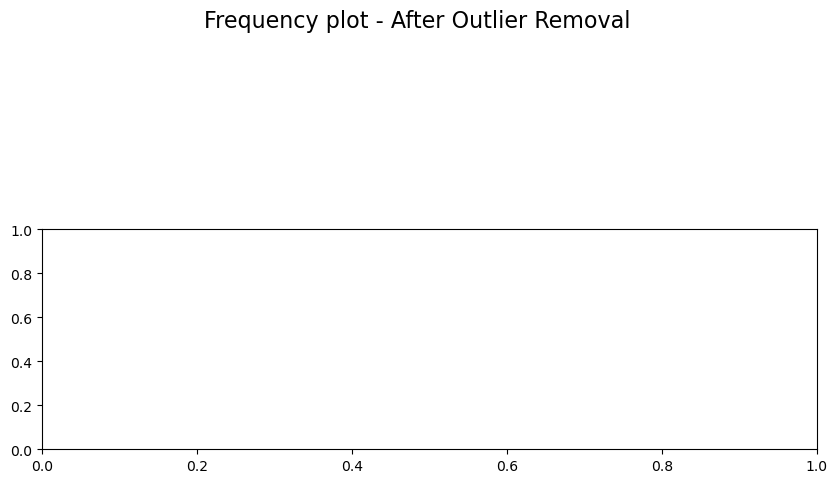

In [9]:
plt.figure(figsize=(10, 20))  # Adjusting the figure size for better visibility
plt.suptitle('Frequency plot - After Outlier Removal', fontsize=16, y=0.99)

# Plotting each feature in a separate row
for i, col in enumerate(data.columns):
    plt.subplot(6, 1, i + 1)  # Creating a subplot for each feature
    sns.histplot(data[col], kde=True)
    sns.countplot(x="bedroomcnt", data=train_df)

    plt.title(f'Frequency of feature {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    break


plt.tight_layout()
plt.show()

Before scaling the data, we need to divide our dataset into train-test set, so that we fit our scaling on training, and scale the test set accordingly.
Handling missing values: I dropped any rows with missing feature value from training_set (given that there were only a handful of them, dropping seemed ok), and in test_set, any missing feature is replaced with the corresponding feature's test_set mean. 

In [5]:
y = data[["Y"]]
X = data.drop(['Y'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Step 1: Identify the rows with missing values in any column
missing_rows = X_train.index[X_train.isna().any(axis=1)]
# Step 2: Drop these rows from X_train
X_train = X_train.drop(missing_rows)
# Step 3: Drop the corresponding rows from y_train
y_train = y_train.drop(missing_rows)

X_test = X_test.fillna(X_test.mean())

Given that we aim to use Linear regression, we need to scale our features to be within the same range. 
We scale all features using standard_scaler. I also tried robust_scaler to see which one gives better results, and standard_scaler was better.

(I initially used log scaling - which is now commented out, but I realized the long tail of features 0, 2, 3 was due to outliers, and i didn't need to use log scaler).
We provide further statistics on the data after scaling.

In [7]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# long_tail_cols = ['0', '2']
# for col in long_tail_cols:
#     min_val = min(X_train_scaled[col].min(), X_test_scaled[col].min())
#     if min_val < 0:
#         X_train_scaled[col] += abs(min_val) + 1   # This shifts the entire X_train column
#         X_test_scaled[col] += abs(min_val) + 1  # This shifts the entire X_test column
#     X_train_scaled[col] = np.log(X_train_scaled[col])
#     X_test_scaled[col] = np.log(X_test_scaled[col])
#     # Calculate 50% of the maximum value
#
#     max_value = X_train_scaled[col].max()
#     cutoff = max_value * 0.4
#
#     # Set values greater than the cutoff to half their value
#     X_train_scaled[col] = X_train_scaled[col].apply(lambda x: x * 0.4 if x > cutoff else x)
#     X_test_scaled[col] = X_test_scaled[col].apply(lambda x: x * 0.4 if x > cutoff else x)
# #

# I also tried robust_scaler to see which one gives better results, and standard_scaler was better
normal_cols = ['0', '1', '2', '3', '4']
standard_scaler = StandardScaler()

X_train_scaled[normal_cols] = standard_scaler.fit_transform(X_train[normal_cols])
X_test_scaled[normal_cols] = standard_scaler.transform(X_test[normal_cols])

y_train[["Y"]] = standard_scaler.fit_transform(y_train[["Y"]])
y_test[["Y"]] = standard_scaler.transform(y_test[["Y"]])



# Statistical summary for X_train_scaled
print("\nStatistical summary of each X_train_scaled value:")
statistical_summary = X_train_scaled.describe()
print(statistical_summary)



Statistical summary of each X_train_scaled value:
                  0             1             2             3             4
count  7.999000e+03  7.999000e+03  7.999000e+03  7.999000e+03  7.999000e+03
mean   2.111075e-17 -1.887615e-17  6.544195e-18  3.887221e-17 -2.653071e-17
std    1.000063e+00  1.000063e+00  1.000063e+00  1.000063e+00  1.000063e+00
min   -3.537737e+00 -3.643465e+00 -3.942786e+00 -4.665536e+00 -3.925401e+00
25%   -6.675238e-01 -6.722315e-01 -6.603029e-01 -6.656927e-01 -6.809028e-01
50%   -1.785168e-03  6.044590e-03  1.055563e-02 -1.760076e-02 -2.906048e-04
75%    6.703698e-01  6.712148e-01  6.675736e-01  6.673668e-01  6.770852e-01
max    3.397023e+00  3.432506e+00  4.675198e+00  4.654324e+00  3.596246e+00


We plotted each feature after scaling. Note, this is after scaling, and after outlier handling. 

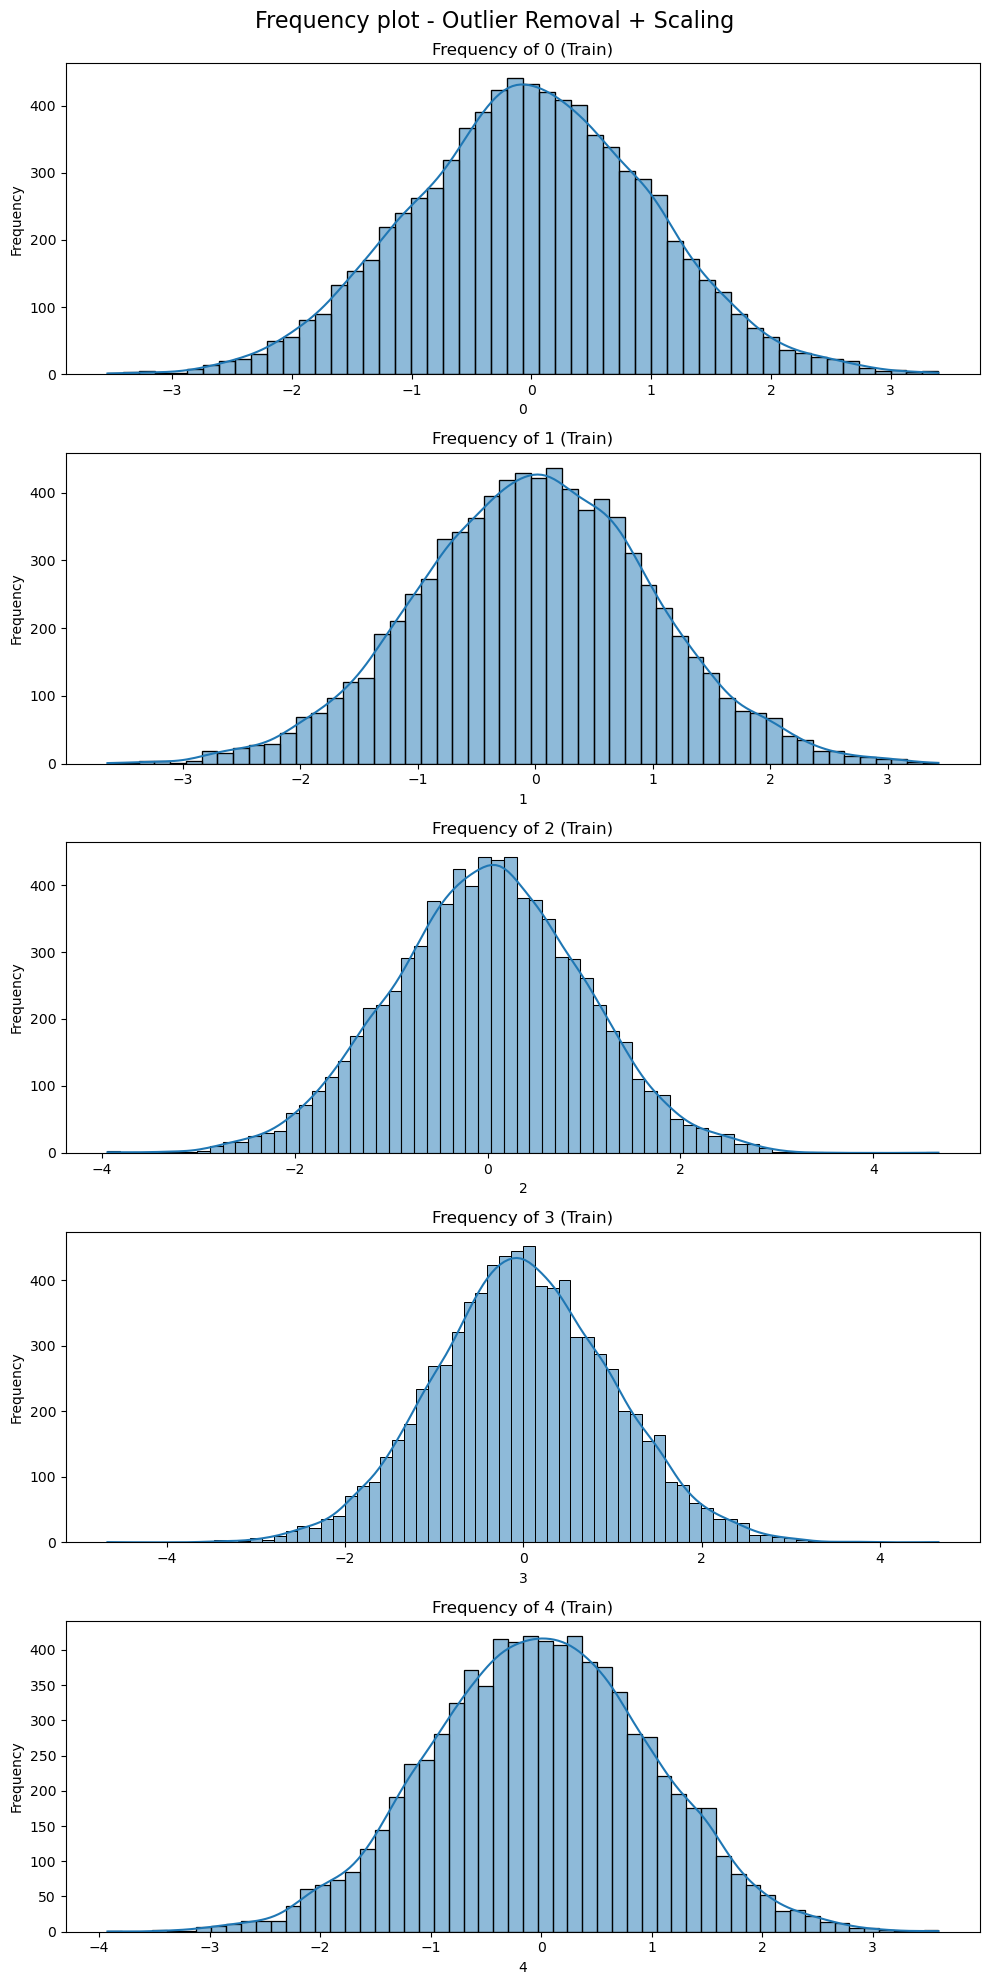

In [8]:
# Plotting each feature in a separate row after removing outliers and scaling the features.
plt.figure(figsize=(10, 20))
plt.suptitle('Frequency plot - Outlier Removal + Scaling', fontsize=16, y=0.99)
for i, col in enumerate(X_train_scaled.columns):
    plt.subplot(5, 1, i + 1)  # Creating a subplot for each feature
    sns.histplot(X_train_scaled[col], kde=True)
    plt.title(f'Frequency of {col} (Train)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Bivariate analysis. One plot to rule them all! 

First plotted the pairplot to see the relationship between each pair of features. Next we provided the heatmap, showing the correlation of features, and correlation of each feature with prediction value Y. 

As we can see, all our features have a very low correlation with Y (except feature 3). We can also see that feature 1 and 4 are highly correlation (given that we only have 4 features, we don't bother doing anything, and leave it up to regularization to handle it. But if we had substantially more features, and some of them were correlation, we might need to take more actions by either dropping one of them, combining the features, etc).

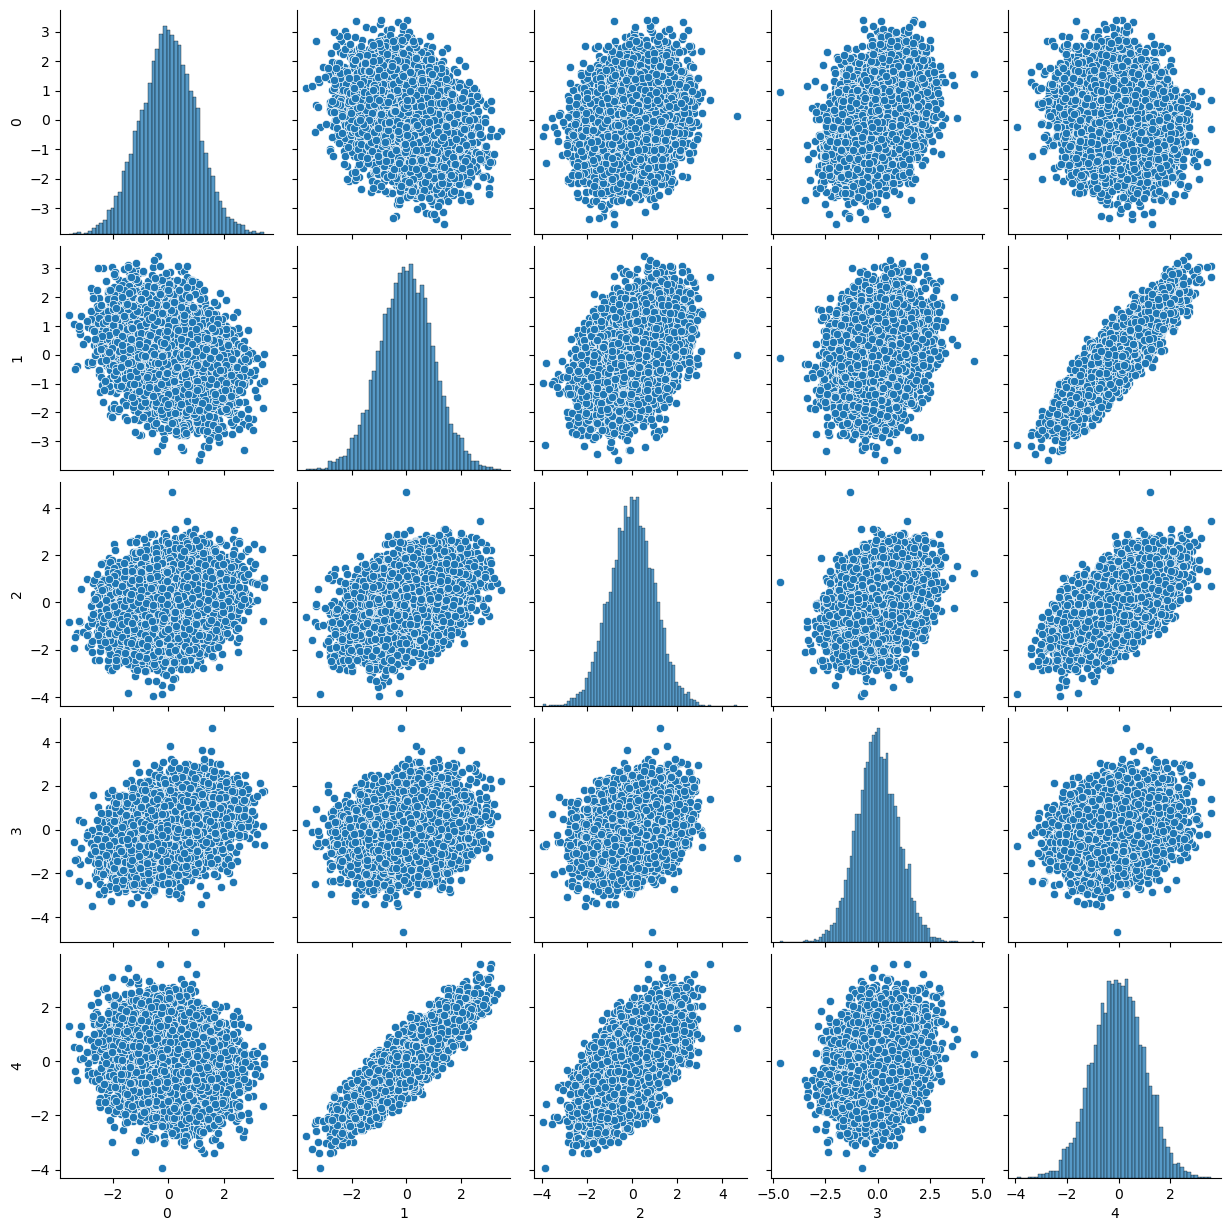

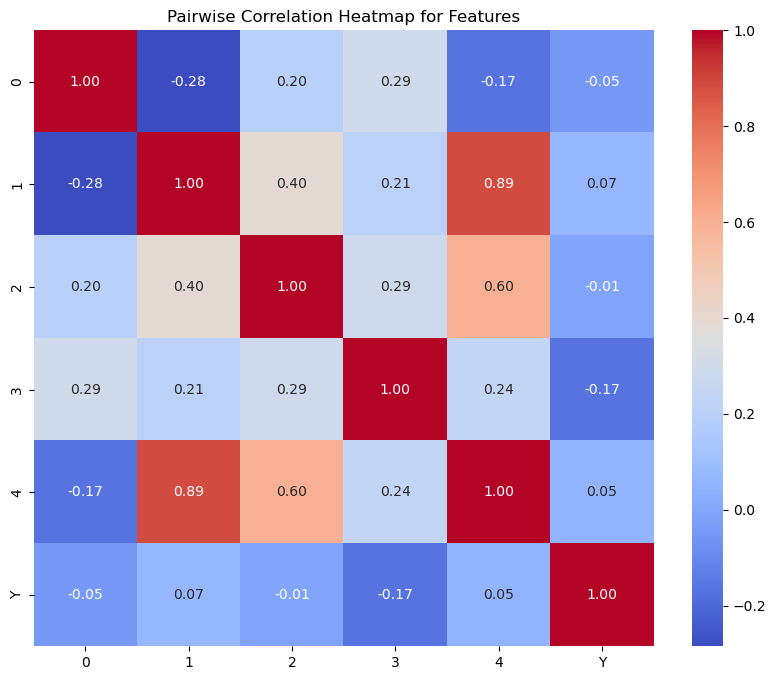

In [10]:
# One plot to rule them all!
# Creating the pairplotv
sns.pairplot(X_train_scaled)
plt.show()


# Calculate the pairwise correlation matrix
X_train_scaled['Y'] = y_train  # Assuming y is a Series. Adjust if y is a DataFrame
correlation_matrix = X_train_scaled.corr()
X_train_scaled.drop(['Y'], axis=1, inplace=True)


# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Pairwise Correlation Heatmap for Features')
plt.show()

 We plot the relationship between each feature and y variable to see how the pairwise distribution lookslike!

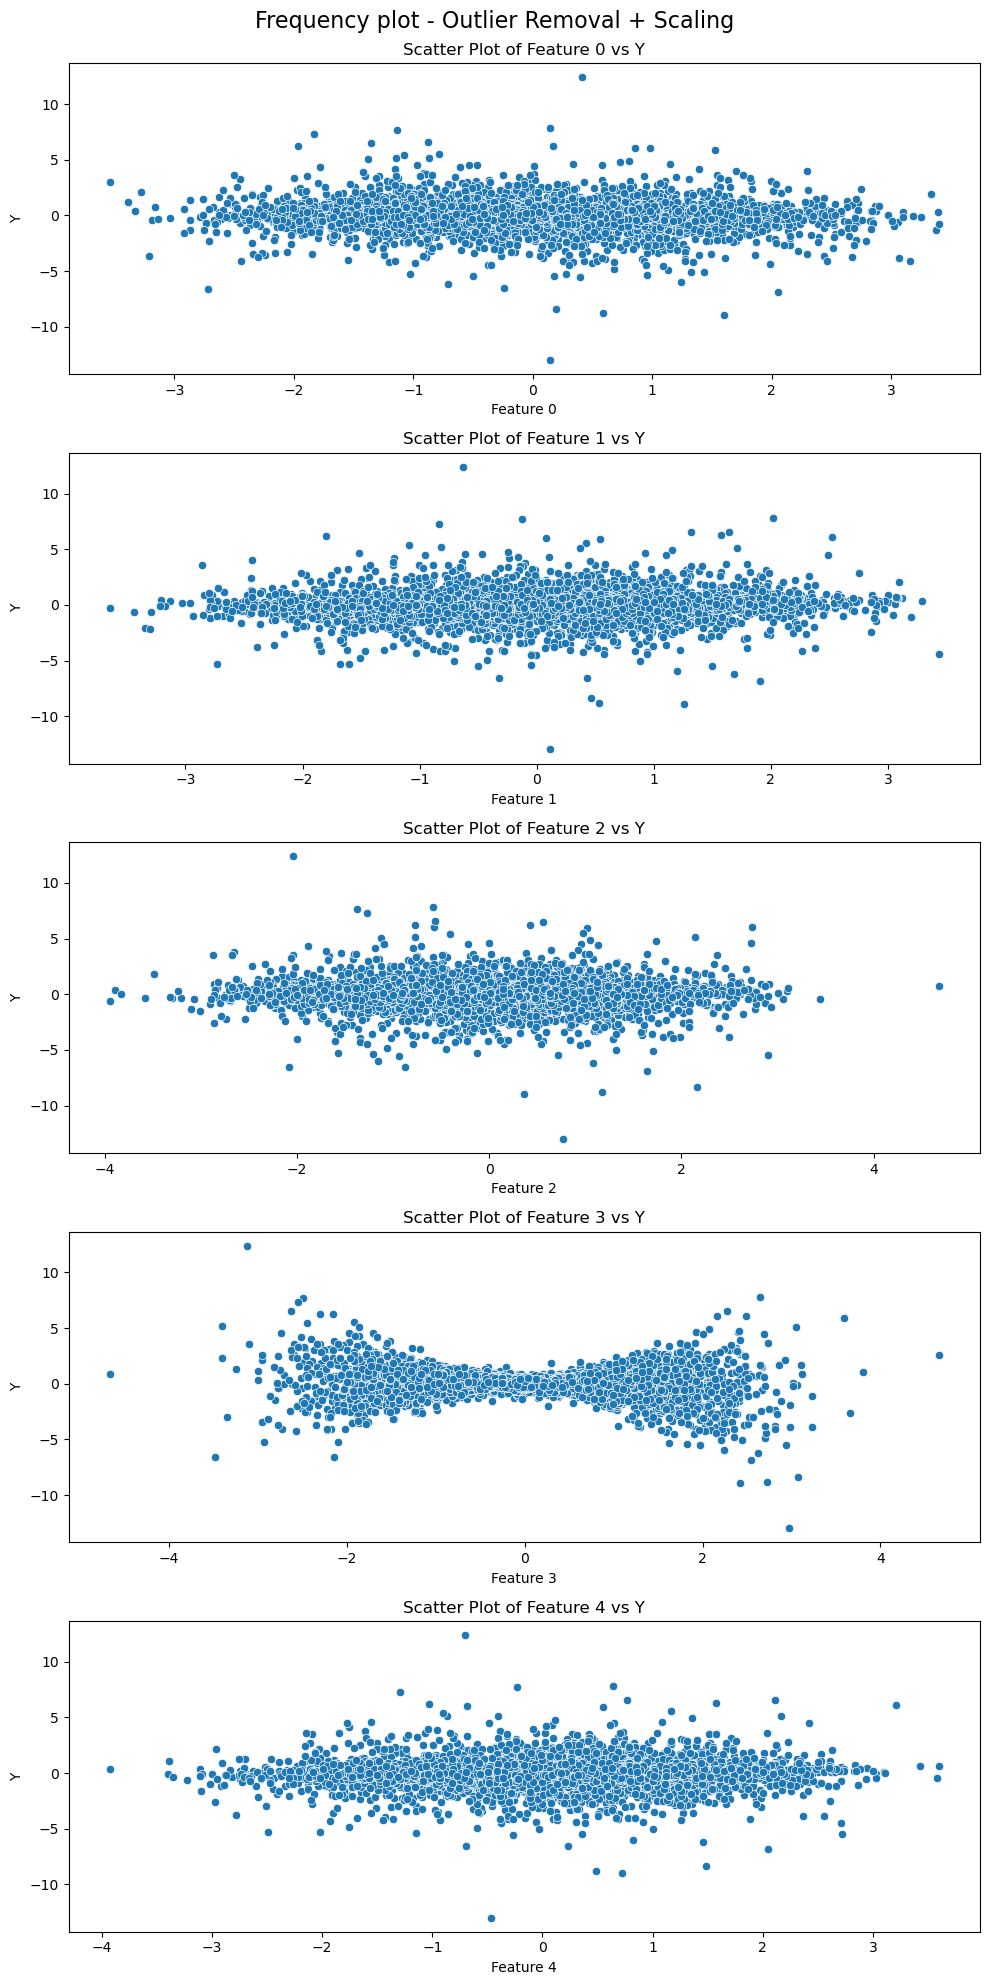

In [11]:
# Scatter plot to visualize the relationship between each feature and the target variable
plt.figure(figsize=(10, 20))
plt.suptitle('Frequency plot - Outlier Removal + Scaling', fontsize=16, y=0.99)
for i, col in enumerate(X.columns):
    plt.subplot(5, 1, i + 1)  # Creating a subplot for each feature
    # Example for one feature, let's say the first feature in your dataset
    feature = X_train_scaled[col]  # Replace with your actual feature name

    # Scatter plot
    # plt.figure(figsize=(8, 6))
    sns.scatterplot(x=feature, y=y_train["Y"])
    plt.title(f'Scatter Plot of Feature {col} vs Y')
    plt.xlabel('Feature ' + col)
    plt.ylabel('Y')
plt.tight_layout()
plt.show()


We consider all feature crosses, by combining multiple features to get a new one, consider all polynomials up to degree 3. 

In [13]:

# Create polynomial features, to consider higher degree relations, and feature cross
poly = PolynomialFeatures(degree=3, include_bias=False)

# Transform the features
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


First we train a model using Ridge regression (Given that we are using all feature crosses of degree 3, we use Ridge regularization to prevent over-fitting)

We use cross validation with cv= 5, to have the best model that is not overfitting.

We also need to tune the alpha/lambda parameter for regularization coefficient. We find the optimal value using grid search. This optimal value = 1000.

We can also see the gap between training and test MSE, and the gap is not large, which is reassures us we (hopefully lol) are not overfitting.

We output the coefficients as well. It is a bit harder to interpret the coefficients now that we have many features, but when we use polynomial degree = 1 (only features themselves, and no feature cross), the set of weights that we see are:  {'0': 0.0474, '1': 0.1233, '2': -0.0218, '3': -0.1994, '4': 0.0136}. As expected, feature 3 has highest absolute weight, which makes sense given that it had the highest correlation. For the training, we continue using polynomial degree = 3, since it gives us better results (we traied various degrees).

In [14]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Define the parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Given that we are using all feature crosses of degree 3, we use Ridge regularization to prevent over-fitting
# Initialize the Ridge regressor
ridge = Ridge()

#  verbose=1 prints basic information
# Initialize GridSearchCV
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_poly, y_train)


# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best training score
print("Best training score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Retrain the model on the full training dataset
best_model.fit(X_train_poly, y_train)

# Predict on the training dataset
y_train_pred = best_model.predict(X_train_poly)

# Compute Mean Squared Error on Training Data
mse_train = mean_squared_error(y_train, y_train_pred)
print("Train: Mean Squared Error (MSE):", mse_train)


# Prediction evaluations:
# Predict on the test set
y_pred = best_model.predict(X_test_poly)

# Compute Mean Squared Error on Test Data
mse_test = mean_squared_error(y_test, y_pred)
print("Test: Mean Squared Error (MSE):", mse_test)

# Compute R^2 Score
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# Get the coefficients
coefficients = best_model.coef_
# pair features with coefficients for easier understanding
feature_names = PolynomialFeatures(degree=3, include_bias=False).fit(X_train).get_feature_names_out()
# Create a dictionary of feature names and coefficients
feature_coefficients = {name: round(coeff, 4) for name, coeff in zip(feature_names, coefficients[0])}
print("feature_coefficients: " + str(feature_coefficients))


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'alpha': 1000}
Best training score: -0.9879087113637016
Train: Mean Squared Error (MSE): 0.9475751274197309
Test: Mean Squared Error (MSE): 0.9248061550696084
R^2 Score: 0.03775174036587303
feature_coefficients: {'0': 0.0164, '1': 0.0577, '2': -0.0023, '3': -0.1017, '4': 0.0256, '0^2': -0.0147, '0 1': -0.0024, '0 2': 0.0112, '0 3': -0.0079, '0 4': -0.0189, '1^2': 0.0026, '1 2': -0.0074, '1 3': 0.023, '1 4': -0.0049, '2^2': 0.0021, '2 3': 0.0504, '2 4': 0.0001, '3^2': -0.0197, '3 4': -0.0311, '4^2': 0.0019, '0^3': 0.001, '0^2 1': 0.0028, '0^2 2': -0.0163, '0^2 3': -0.0051, '0^2 4': -0.0101, '0 1^2': -0.005, '0 1 2': -0.001, '0 1 3': 0.0047, '0 1 4': -0.0008, '0 2^2': 0.0154, '0 2 3': 0.0589, '0 2 4': 0.0143, '0 3^2': 0.022, '0 3 4': -0.0278, '0 4^2': -0.0243, '1^3': 0.002, '1^2 2': 0.0078, '1^2 3': -0.0206, '1^2 4': -0.0179, '1 2^2': 0.0134, '1 2 3': 0.0066, '1 2 4': 0.0255, '1 3^2': 0.0074, '1 3 4': 0.0283, '

The R^2 value is relatively low, but given that non of our features did not have a high correlation with Y, the R^2 might not be crazy bad. 

Next we train an XGBoost model to compare to our Ridge regression. We can see the R^2 and MSE are slightly wosrse. 

In [9]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.7, 0.8],
    'subsample': [0.7, 0.8]
}


# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train_poly, y_train)


# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best training score
print("Best training score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Retrain the model on the full training dataset
best_model.fit(X_train_poly, y_train)

# Predict on the training dataset
y_train_pred = best_model.predict(X_train_poly)

# Compute Mean Squared Error on Training Data
mse_train = mean_squared_error(y_train, y_train_pred)
print("Train: Mean Squared Error (MSE):", mse_train)


# Prediction evaluations:
# Predict on the test set
y_pred = best_model.predict(X_test_poly)

# Compute Mean Squared Error on Test Data
mse_test = mean_squared_error(y_test, y_pred)
print("Test: Mean Squared Error (MSE):", mse_test)

# Compute R^2 Score
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

NameError: name 'X_train_poly' is not defined

Residual Analysis: we continue our analysis for the better model (which in this case is Ridge regression - I made sure to run the regression last before starting this code). We want to understand where our model did wrong, and if we can get any intuition on the model to improve it. 
We plotting the Predicted vs Actual Values for X_test (observation: we are underestimating the larger y_test, and underestimating the small ones), the histogram of residuals (observation: We can see our residuals are from normally distributed), and a quantile-quantile plot of residuals. 

In [10]:

# Plotting Predicted vs Actual Values for X_test
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Diagonal line for reference
plt.show()


# Compute residuals
residuals = y_test - y_pred
residuals = np.ravel(residuals)

# Residuals vs. Predicted values plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q (quantile-quantile) plot of residuals
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


NameError: name 'y_test' is not defined

<Figure size 800x600 with 0 Axes>